In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from sklearn.tree import DecisionTreeRegressor
import glob
from astropy import units as u
from sklearn.cluster import HDBSCAN
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
class fit_obj:

    """
    class to handle multiple SDSS fits files and perform ML analysis on them
    """


    def __init__(self, fits_glob):
        self.fits_files=glob.glob(fits_glob)
        self.spec_data=[]
        self.spec_header=[]
        

    def load_fits_data(self):
        print(self.fits_files)
        for i in self.fits_files:
            with fits.open(i) as fit_file:
                specdata=fit_file[1].data
                specheader=fit_file[0].header
                self.spec_data.append(specdata)
                self.spec_header.append(specheader)

    def show_header(self):
        for i in self.spec_header:
            print("\n")
            print(i)
    
    def spec_rearrange(self):

        #Get the shapes of each spectra then find the smallest shape along 0 axis
        spec_shape_list=[]
        for i in self.spec_data:
            spec_shape_list.append(i.shape)

        spec_shape_list=np.array(spec_shape_list)

        # Finding a target lenght for filtering
        target_length = sum((3.582 <= lam <= 3.957) for lam in self.spec_data[0].loglam)

        #Performing filtering of the spectra along lambda axis as data is not recording properly from first lambda
        #to last lambda, as in some spectra the measurements start from different first to different last lambda
        spectra_filtered_list=[]
        for i in self.spec_data:
            spec=i
            #apply booleam mask along lambda axis from 3.562 to 3.957 lambdas
            mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
            filtered_data = spec[mask]

                # Adjust the length to match target_length
            if len(filtered_data) < target_length:
                # If shorter, pad with NaNs or another value of choice and relpace missing vals with mean of the spectrum
                filtered_data = np.pad(filtered_data, (0, target_length - len(filtered_data)), constant_values=np.mean(filtered_data['sky'])) 
            elif len(filtered_data) > target_length:
                # If longer, truncate
                filtered_data = filtered_data[:target_length]
            spectra_filtered_list.append(filtered_data)




        #And here we have a np array containing individual spectras
        self.spectra_filtered_list_array=np.array(spectra_filtered_list)
        print('After realigning the spectra wrt halpha wavelenght')
        print(self.spectra_filtered_list_array.shape)

    def compare_ml_reg_models(self):
        indices= np.arange(self.spectra_filtered_list_array.shape[0]).reshape(-1,1)
        ml_regression_methods=[DecisionTreeRegressor(),RandomForestRegressor(), LinearRegression()]

        master_sky_spectrum_list=[]
        for ml_reg in ml_regression_methods:
            ml_reg.fit(indices, self.spectra_filtered_list_array['sky'])

            #Generate the master sky from prediction
            master_sky=ml_reg.predict( np.array(0).reshape(-1,1))
            master_sky_spectrum_list.append(master_sky)


        #scaling the master sky to the science spectra
        ref_master= master_sky_spectrum_list[0][0][3600:3700]    # a piece of mast sky from any of the 3 ml reg methods
        ref_sky=self.spectra_filtered_list_array[0]['sky'][3600:3700] #a piece of sky from any of the1 50 spectra
        scaling=np.mean(ref_sky/ref_master)
        scaled_master_sky_spectrum_list=[]
        for i in master_sky_spectrum_list:
            master_scaled=i*scaling
            scaled_master_sky_spectrum_list.append(master_scaled)

        

        #scaling plots comparison

        fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,14))

        spectra_no=41
        ax[0].plot(self.spectra_filtered_list_array['sky'][spectra_no], c='r')
        ax[0].plot(scaled_master_sky_spectrum_list[0][0])
        ax[0].set_title( f"{ml_regression_methods[0]} VS sky for a fibre")
        ax[0].set_xlabel('wavelenght bins')
        ax[0].set_ylabel('Flux')

        ax[1].plot(self.spectra_filtered_list_array['sky'][spectra_no], c='r')
        ax[1].plot(scaled_master_sky_spectrum_list[1][0])
        ax[1].set_title( f"{ml_regression_methods[1]} VS sky for a fibre")
        ax[1].set_xlabel('wavelenght bins')
        ax[1].set_ylabel('Flux')

        ax[2].plot(self.spectra_filtered_list_array['sky'][spectra_no], c='r')
        ax[2].plot(scaled_master_sky_spectrum_list[2][0])
        ax[2].set_title( f"{ml_regression_methods[2]} VS sky for a fibre")
        ax[2].set_xlabel('wavelenght bins')
        ax[2].set_ylabel('Flux')




        """
        #Subtract the master from one of the fibers to get residuals
        sub=master_scaled- spectra_filtered_list_sky_array[1]
        #Convert to flux units
        sub_flux = sub* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
        sky_flux=self.spectra_filtered_list['sky'][1]* 10**-17 * u.Unit('erg cm-2 s-1 AA-1') 
        master_sky_flux=master_sky_spectrum* 10**-17 * u.Unit('erg cm-2 s-1 AA-1')     
        fig,ax=plt.subplots(nrows=3,ncols=1,figsize=(10,7))
        ax[0].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA,
                   sub_flux, label='residual (sub from master sky)')
        ax[0].legend()
        #Convert to flux units
        ax[1].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA, 
                   sky_flux, label='sky')
        ax[1].legend()
        ax[2].plot(10**self.spectra_filtered_list[1]['loglam'] * u.AA, 
                   master_sky_flux, label='master_sky from DTR')
        ax[2].legend()
        ax[0].set_title('Effects of Decison Tree for master sky from {0} fibres'.format(self.spectra_filtered_list.shape[0]))
        """

 
    def fibre_correlation_plot(self, fibre_1, fibre_2):
        self.fibre_1=fibre_1
        self.fibre_2=fibre_2
        plt.figure(figsize=(5,5))
        plt.scatter( self.spectra_filtered_list_array[self.fibre_1]['sky'], 
                    self.spectra_filtered_list_array[self.fibre_2]['sky'], marker='.')
        plt.yscale('log')
        plt.xscale('log')
        plt.title('Correlation among multiple fibres')
    


    def hdbscan_skylines_detection(self):

        cluster_array=np.array([self.spectra_filtered_list_array[self.fibre_1]['sky'], 
                                self.spectra_filtered_list_array[self.fibre_2]['sky']]).T   
        cluster= HDBSCAN(min_cluster_size=20, min_samples=20)
        cluster.fit( cluster_array  )
         
        plt.scatter(cluster_array[:,0],cluster_array[:,1], marker='.', c= cluster.labels_)
        plt.yscale('log')
        plt.xscale('log')
                    
        labels=cluster.labels_
        plt.figure(figsize=(5,5))
        flux= cluster_array[:,0]
        wave=np.arange(len(flux))
        plt.scatter(wave, flux, c=labels, marker='*')

        discard_label= labels==-1
        cluster_array[discard_label,:]=np.nan

        plt.figure(figsize=(10,2))
        plt.plot(cluster_array[:,0])

        plt.figure(figsize=(10,4))

        plt.plot(self.spectra_filtered_list_array[self.fibre_2]['sky'])
        plt.plot(cluster_array[:,1])


                           

['sdss_fits_files/spec-1944-53385-0536.fits', 'sdss_fits_files/spec-2341-53738-0567.fits', 'sdss_fits_files/spec-2297-53738-0160.fits', 'sdss_fits_files/spec-2297-53738-0221.fits', 'sdss_fits_files/spec-1947-53431-0343.fits', 'sdss_fits_files/spec-1947-53431-0275.fits', 'sdss_fits_files/spec-1950-53436-0244.fits', 'sdss_fits_files/spec-2342-53742-0406.fits', 'sdss_fits_files/spec-2342-53742-0148.fits', 'sdss_fits_files/spec-2296-53735-0441.fits', 'sdss_fits_files/spec-2344-53740-0238.fits', 'sdss_fits_files/spec-1950-53436-0200.fits', 'sdss_fits_files/spec-2342-53742-0491.fits', 'sdss_fits_files/spec-2342-53742-0337.fits', 'sdss_fits_files/spec-1947-53431-0034.fits', 'sdss_fits_files/spec-2297-53738-0516.fits', 'sdss_fits_files/spec-2297-53738-0617.fits', 'sdss_fits_files/spec-1947-53431-0020.fits', 'sdss_fits_files/spec-1947-53431-0181.fits', 'sdss_fits_files/spec-1947-53431-0072.fits', 'sdss_fits_files/spec-1947-53431-0624.fits', 'sdss_fits_files/spec-2342-53742-0511.fits', 'sdss_fit

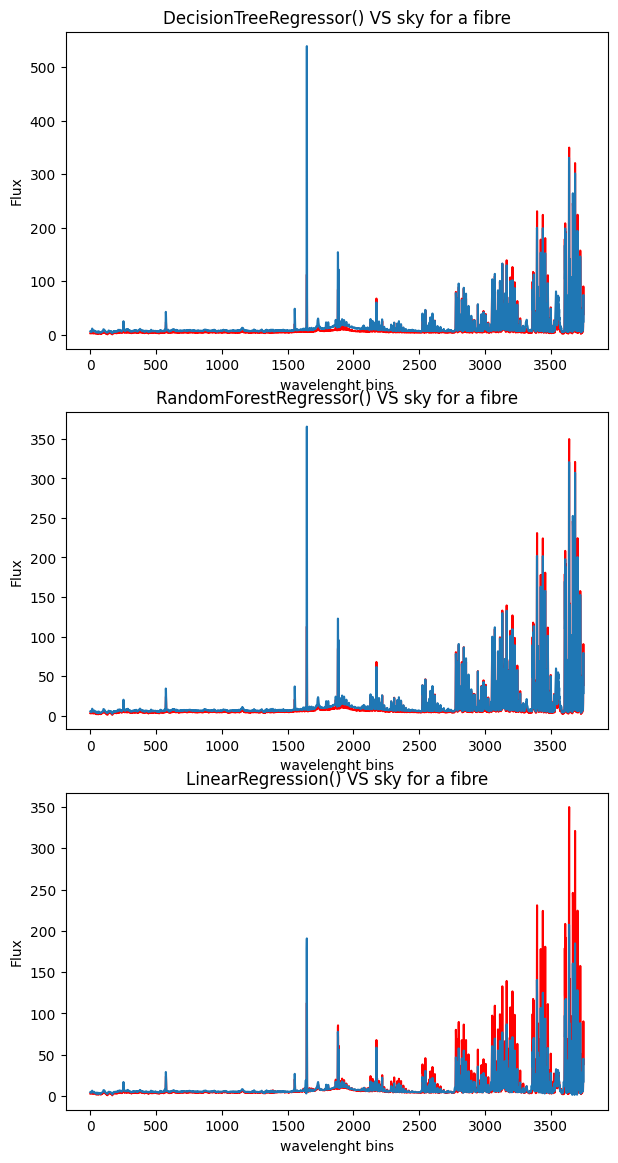

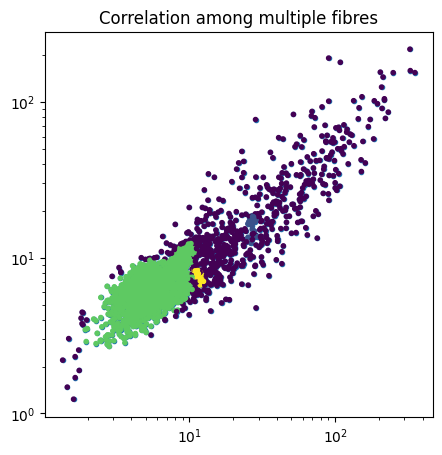

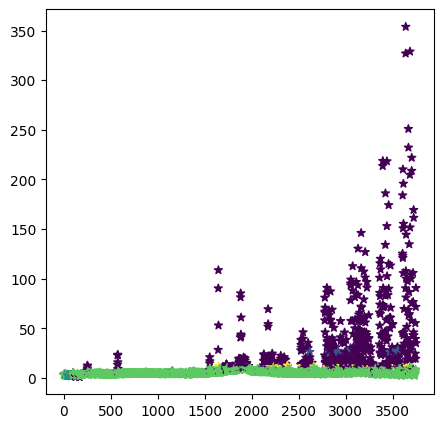

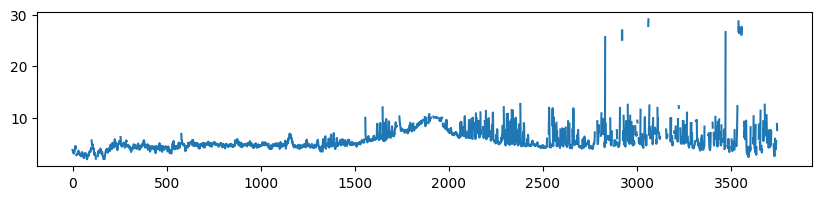

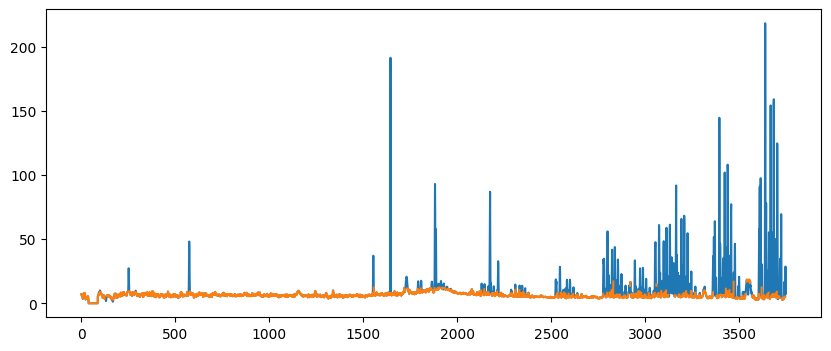

In [5]:
my_fits=fit_obj('sdss_fits_files/*.fits')

my_fits.load_fits_data()

my_fits.spec_rearrange()
my_fits.compare_ml_reg_models()
my_fits.fibre_correlation_plot(1,4)
my_fits.hdbscan_skylines_detection()


